### Use single-cell RNA-seq clusters to predict cell type compistion for each validation bulk RNA-seq sample
### Fan Zhang
### 2018-11-29

In [91]:
library(MASS)
library(matrixStats)
library(ggplot2)
library(reshape)
library(cowplot)
library(dplyr)
library(limma)
library(stringr)
library(data.table)
require(gdata)
library(readr)
library(ggplot2)
library(gridExtra)
require(scales)
library(stringr)
library(matrixStats)
library(viridis)
library(patchwork)
library(RColorBrewer)
library(limma)
library(pbapply)
library(parallel)
library(ggrepel)
library(pheatmap)

source("/data/srlab/fzhang/amp/data/meta_colors.R")
source("../2017_01_12_Low_input_RA_RNA_seq_data_analysis/pca_Kam.R")
source("../2017_02_28_Phase1_cellseq_RA_single_cell_data/pure_functions.R")

meta_colors$flow_marker = c(
    "CD11c-IgD-CD27+" = "#8DD3C7",
    "CD11c-IgD+CD27-" = "#FFFFB3",
    "CD14+CD11c+++CD38+++" = "#BEBADA",
    "CD14+CD11c++CD38-" = "#FB8072",
    "CD14+CD11c+CD38++" = "#80B1D3",
    "CD19+CD11c+" = "#FDB462",
    "CD90- DR-" = "#B3DE69", 
    "CD90- DR+" = "#FCCDE5",
    "CD90+ DR-" = "#D9D9D9",
    "CD90+ DR+" = "#BC80BD",
    "PC" = "#CCEBC5"
)

In [71]:
## Load validation bulk samples
log2tpm <- readRDS("postQC_log2tpm.rds")
good_meta <- readRDS("postQC_meta.rds")

type <- "Fibroblasts"
log2tpm_type <- log2tpm[, which(good_meta$cell_type == type)]
meta_type <- good_meta[which(good_meta$cell_type == type), ]

# Remove CD90- DR- samples
log2tpm_type <- log2tpm_type[, -which(meta_type$flow_marker == "CD90- DR+")]
meta_type <- meta_type[-which(meta_type$flow_marker == "CD90- DR+"),]
# Remove 3 OA from CD90+DR+
log2tpm_type <- log2tpm_type[, -which(meta_type$flow_marker == "CD90+ DR+" & meta_type$disease == "OA")]
meta_type <- meta_type[-which(meta_type$flow_marker == "CD90+ DR+" & meta_type$disease == "OA"),]
# Remove 6 RA from CD90-DR-
log2tpm_type <- log2tpm_type[, -which(meta_type$flow_marker == "CD90- DR-" & meta_type$disease == "RA")]
meta_type <- meta_type[-which(meta_type$flow_marker == "CD90- DR-" & meta_type$disease == "RA"),]
# Remove B4
log2tpm_type <- log2tpm_type[, -which(meta_type$sample_ID == "B4")]
meta_type <- meta_type[-which(meta_type$sample_ID == "B4"),]
# Remove B1
log2tpm_type <- log2tpm_type[, -which(meta_type$sample_ID == "B1")]
meta_type <- meta_type[-which(meta_type$sample_ID == "B1"),]

all(colnames(log2tpm_type) == meta_type$sample_ID)
table(meta_type$flow_marker, meta_type$disease)

## Load amp single-cell data
ra_log2cpm <- readRDS("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/celseq_synovium_log2_5265cells_paper.rds")
ra_meta <- readRDS("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/celseq_synovium_meta_5265cells_paper.rds")

type <- "Fibroblast"
sc_log2cpm <- ra_log2cpm[, which(ra_meta$cell_type == type)]
sc_meta <- ra_meta[which(ra_meta$cell_type == type), ]
all(sc_meta$cell_name == colnames(sc_log2cpm))
table(sc_meta$cluster)

[1] TRUE

           
            OA RA
  CD90- DR-  4  0
  CD90+ DR-  4  6
  CD90+ DR+  0  6

[1] TRUE


SC-F1 SC-F2 SC-F3 SC-F4 
  484   719   228   413 

In [18]:
auroc <- function(score, cls) {
  n1 <- sum(!cls)
  n2 <- sum(cls)
  U <- sum(rank(score)[!cls]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

get_markers <- function(log2cpm, cell_clusters) {
  # Compute statistics for each cluster.
  dat_marker <- rbindlist(pblapply(
    X = rownames(log2cpm),
    cl = 20,
    FUN = function(gene_name) {
      gene      <- as.numeric(log2cpm[gene_name,])
      rbindlist(lapply(unique(cell_clusters), function(cell_cluster) {
        ix <- cell_clusters == cell_cluster
        x <- gene[ix]
        x_mean <- mean(x)
        x_sd   <- sd(x)
        x_pct_nonzero <- sum(x > 0) / length(x)
        y <- gene[!ix]
        y_mean <- mean(y)
        y_sd   <- sd(y)
        y_pct_nonzero <- sum(y > 0) / length(y)
        test_w <- wilcox.test(x, y, alternative = "two.sided")
        test_t <- t.test(x, y, alternative = "two.sided")
        data.frame(
          "gene"              = gene_name,
          "cluster"           = cell_cluster,
          "wilcox_pvalue"     = test_w$p.value,
          "ttest_pvalue"      = test_t$p.value,
          "auc"               = auroc(gene, ix),
          "pct_nonzero"       = x_pct_nonzero,
          "pct_nonzero_other" = y_pct_nonzero,
          "log2FC"            = x_mean - y_mean,
          "mean"              = x_mean,
          "sd"                = x_sd,
          "mean_other"        = y_mean,
          "sd_other"          = y_sd
        )
      }))
    }
  ))
  # Check if the mean is highest in this cluster.
  dat_marker[
    ,
    mean_highest := mean >= max(mean),
    by = gene
  ]
  dat_marker[
    ,
    pct_nonzero_highest := pct_nonzero >= max(pct_nonzero),
    by = gene
  ]
  return(dat_marker)
}

# Test each cluster against all cells.
dat_marker_sc <- get_markers(
    sc_log2cpm, 
    sc_meta$cluster
)
saveRDS(dat_marker_sc, "fibroblast_dat_marker_sc.rds")

In [72]:
# dat_marker_sc <- readRDS("fibroblast_dat_marker_sc.rds")
x <- dat_marker_sc %>%
  group_by(cluster) %>%
  top_n(500, wt = auc) # 50 gave me an OK result

good_features <- unique(x$gene)
length(good_features)

[1] 1706

In [73]:
# Use the intersected features for both sides
log2cpm_filtered <-  as.data.frame(sc_log2cpm)
log2cpm_filtered <- log2cpm_filtered[which(rownames(as.data.frame(log2cpm_filtered)) %in% good_features),]

# Take intersected genes
inter <- intersect(rownames(log2cpm_filtered), rownames(log2tpm_type))
length(inter)

log2tpm_type <- log2tpm_type[inter,]
log2cpm_filtered <- log2cpm_filtered[inter, ]
all(rownames(log2tpm_type) == rownames(log2cpm_filtered))

dim(log2cpm_filtered)
dim(log2tpm_type)

[1] 1652

[1] TRUE

[1] 1652 1844

[1] 1652   20

In [74]:
all(colnames(log2cpm_filtered) == sc_meta$cell_name)
log2cpm_filtered <- as.data.frame(t(log2cpm_filtered))
log2cpm_filtered <- as.data.frame(scale(log2cpm_filtered))
log2cpm_filtered$cluster <- sc_meta$cluster
table(log2cpm_filtered$cluster)

log2tpm_type <- as.data.frame(t(log2tpm_type))
log2tpm_type <- as.data.frame(scale(log2tpm_type))

[1] TRUE


SC-F1 SC-F2 SC-F3 SC-F4 
  484   719   228   413 

### Perform LDA

In [75]:
r <- lda(formula = cluster ~ ., 
         data = log2cpm_filtered,
         prior = c(1,1,1,1)/4
        )

[1] TRUE

null device 
          1

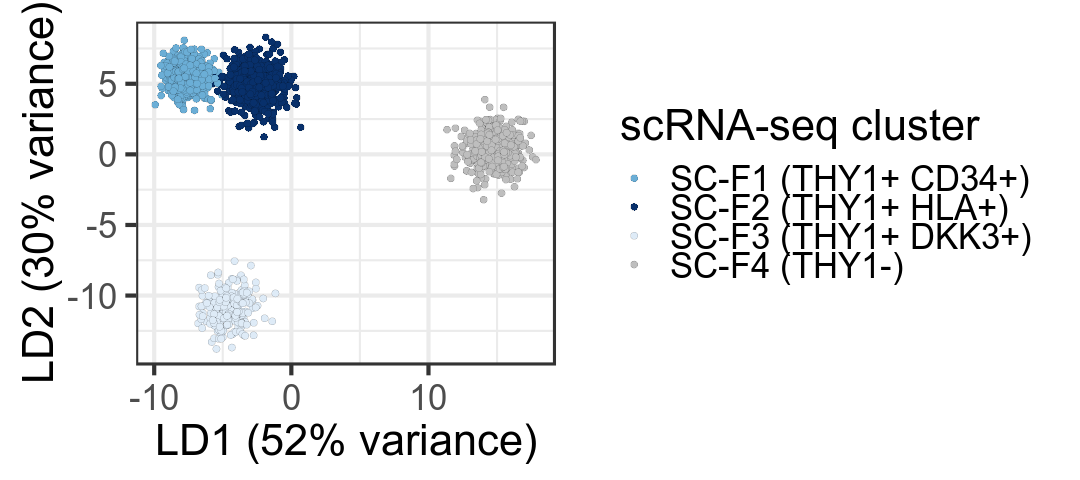

In [77]:
r.values <- predict(r)

ld_plot <- as.data.frame(r.values$x)
all(rownames(ld_plot) == sc_meta$cell_name)
ld_plot$cluster <- sc_meta$cluster # paste("SC-F", sc_meta$cluster, sep="")
ld_plot$disease <- sc_meta$disease

# Variance explained
prop = r$svd^2/sum(r$svd^2)

options(repr.plot.height = 4, repr.plot.width = 9)
p1 <- ggplot() +
  geom_point(
    data = ld_plot,
    mapping = aes(LD1, LD2, fill = cluster),
    shape = 21, size = 2, stroke = 0.05
  ) +
  scale_fill_manual(labels = c("SC-F1 (THY1+ CD34+)", "SC-F2 (THY1+ HLA+)", "SC-F3 (THY1+ DKK3+)", "SC-F4 (THY1-)"),
                    values = meta_colors$fine_cluster, name = "scRNA-seq cluster") +
  labs(x = paste0("LD1 (", as.numeric(format(prop[1], digits = 2))*100, "% variance)", sep=""),
       y = paste0("LD2 (", as.numeric(format(prop[2], digits = 2))*100, "% variance)", sep="")
       ) +
  theme_bw(base_size = 26)+
  theme(
#     legend.position = "none",
    # axis.text = element_blank(),
    # axis.ticks = element_blank(),
    # panel.grid = element_blank()
  ) 
p1 <- p1 +  guides(colour = guide_legend(override.aes = list(size=5))) 
p1

# p2 <- ggplot() +
#   geom_point(
#     data = ld_plot,
#     mapping = aes(LD1, LD2, fill = disease),
#     shape = 21, size = 1.5, stroke = 0.1
#   ) +
#   scale_fill_manual(values = meta_colors$Case.Control, name = "disease") +
#   labs(x = paste0("LD1 (", as.numeric(format(prop[1], digits = 2))*100, "% variance)", sep=""),
#        y = paste0("LD2 (", as.numeric(format(prop[2], digits = 2))*100, "% variance)", sep="")
#        ) +
#   theme_bw(base_size = 15)+
#   theme(
#     legend.position = "none"
#     # axis.text = element_blank(),
#     # axis.ticks = element_blank(),
#     # panel.grid = element_blank()
#   ) 
# plot_grid(p1, p2, nrow = 1)
ggsave(file = paste("v3_LDA_sc_", type, ".png", sep = ""), width = 8.3, height = 4, dpi = 300)
dev.off()

### Predict on bulk samples

In [78]:
plda = predict(object = r, # predictions
               newdata = log2tpm_type)

[1] TRUE

null device 
          1

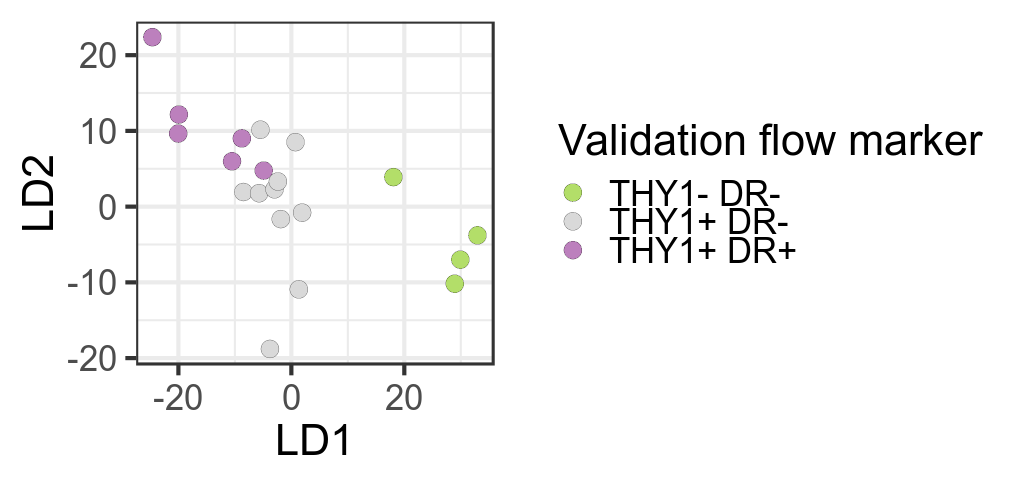

In [84]:
ld_plot <- as.data.frame(plda$x)
all(rownames(ld_plot) == meta_type$sample_ID)
ld_plot$flow_marker <- meta_type$flow_marker
ld_plot$disease <- meta_type$disease
ld_plot$sample_ID <- rownames(ld_plot)


options(repr.plot.height = 4, repr.plot.width = 8.5)
ggplot() +
  geom_point(
    data = ld_plot,
    mapping = aes(LD1, LD2, fill = flow_marker),
    shape = 21, size = 5, stroke = 0.1
  ) +
#   geom_text(
#     data = ld_plot,
#     mapping = aes(LD1, LD2, label = sample_ID),
#     size = 3,
#     hjust = 0,
#     vjust = 0
#   ) +
  scale_fill_manual(labels = c("THY1- DR-", "THY1+ DR-", "THY1+ DR+"), 
                    values = meta_colors$flow_marker,
                    name = "Validation flow marker") +
#   labs(x = paste0("LD1 (", as.numeric(format(prop[1], digits = 2))*100, "% variance)", sep=""),
#        y = paste0("LD1 (", as.numeric(format(prop[2], digits = 2))*100, "% variance)", sep="")
#     ) +
  theme_bw(base_size = 26)+
  theme(
    # legend.position = "none",
    # axis.text = element_blank(),
    # axis.ticks = element_blank(),
    # panel.grid = element_blank()
  ) 
ggsave(file = paste("v3_LDA_bulk_", type, ".png", sep = ""), width = 8.3, height = 4, dpi = 300)
dev.off()

### Get posterior for each sample

In [48]:
poster <- as.data.frame(plda$posterior)
poster$sample_ID <- rownames(poster)
all(poster$sample_ID == meta_type$sample_ID)
poster$flow_marker <- meta_type$flow_marker
poster_plot <- melt(poster)

[1] TRUE

Using sample_ID, flow_marker as id variables


### Plot posterior for each cell

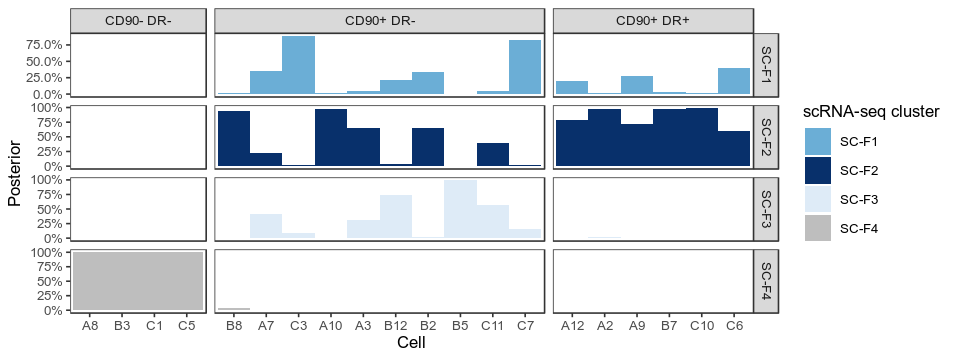

In [49]:
options(repr.plot.height = 3, repr.plot.width = 8)
ggplot(
  data=poster_plot,
  aes(x=reorder(sample_ID, value), y= value, fill = variable)
  ) +
  geom_bar(
           stat="identity",
#            position = "fill",
           position = "stack",
           width = 1
  ) +
  scale_y_continuous(labels = scales::percent) +
  facet_grid(variable ~ flow_marker, scales = "free", space = "free_x") +
  scale_fill_manual(values = meta_colors$fine_cluster, name = "scRNA-seq cluster") +
  labs(x="Cell", y="Posterior") +
  theme_bw(base_size = 10)+
  theme(
#     legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank()
  ) 
# ggsave(file = paste("v2_posterior_", type, ".png", sep = ""), width = 12, height = 7, dpi = 300)
# dev.off()

In [50]:
x <- cbind(meta_type, plda$posterior, plda$x) %>%
dplyr::select(sample_ID, flow_marker, "SC-F1", "SC-F2", "SC-F3", "SC-F4") %>%
tidyr::gather(key = "posterior_label", value = "posterior_value", -sample_ID, -flow_marker)

hc1 <- hclust(dist(plda$posterior))
x$cell_name <- factor(x$sample_ID, levels = rownames(plda$posterior)[hc1$order])

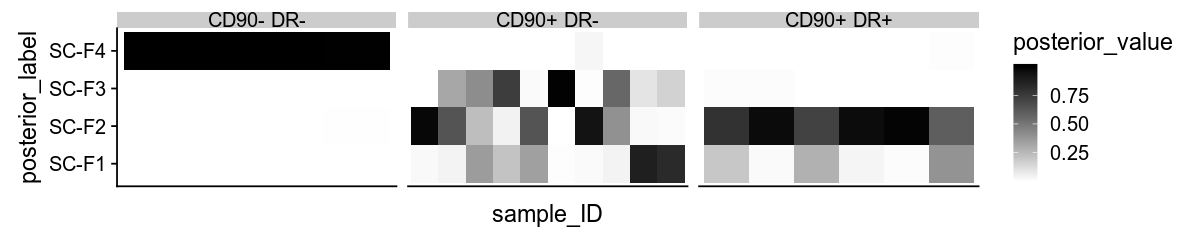

In [51]:
options(repr.plot.height = 2, repr.plot.width = 10)
ggplot(x) +
aes(x = sample_ID, y = posterior_label, fill = posterior_value) +
geom_tile() +
theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
facet_wrap(~ flow_marker, scales = "free_x", ncol = 4) +
scale_fill_gradient2(low = "white", high = "black")

null device 
          1

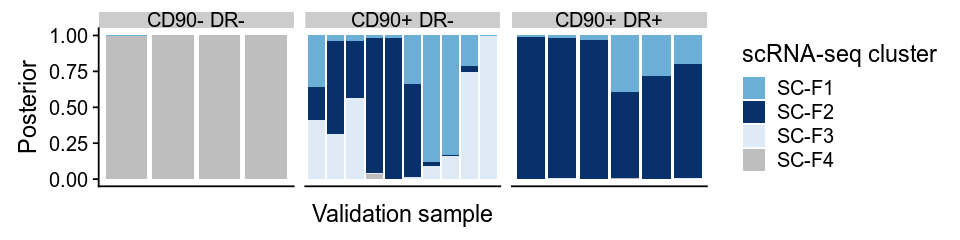

In [53]:
options(repr.plot.height = 2, repr.plot.width = 8)
ggplot(x) +
aes(x = cell_name, fill = posterior_label, weight = posterior_value) +
geom_bar() +
scale_fill_manual(values = meta_colors$fine_cluster, name = "scRNA-seq cluster") +
theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
facet_wrap(~ flow_marker, scales = "free_x", ncol = 4) +
labs(x="Validation sample", y="Posterior") 

ggsave(file = paste("v3_LDA_sc_", type, "_barplot", ".png", sep = ""), width = 8, height = 2, dpi = 300)
dev.off()

### Heatmap 

In [162]:
log2tpm <- readRDS("postQC_log2tpm.rds")
good_meta <- readRDS("postQC_meta.rds")

type <- "Fibroblasts"
log2tpm_type <- log2tpm[, which(good_meta$cell_type == type)]
meta_type <- good_meta[which(good_meta$cell_type == type), ]

# Remove CD90- DR- samples
log2tpm_type <- log2tpm_type[, -which(meta_type$flow_marker == "CD90- DR+")]
meta_type <- meta_type[-which(meta_type$flow_marker == "CD90- DR+"),]
# Remove CD90+ DR- samples
log2tpm_type <- log2tpm_type[, -which(meta_type$flow_marker == "CD90+ DR-")]
meta_type <- meta_type[-which(meta_type$flow_marker == "CD90+ DR-"),]
# Remove 3 OA from CD90+DR+
log2tpm_type <- log2tpm_type[, -which(meta_type$flow_marker == "CD90+ DR+" & meta_type$disease == "OA")]
meta_type <- meta_type[-which(meta_type$flow_marker == "CD90+ DR+" & meta_type$disease == "OA"),]
# Remove 6 RA from CD90-DR-
log2tpm_type <- log2tpm_type[, -which(meta_type$flow_marker == "CD90- DR-" & meta_type$disease == "RA")]
meta_type <- meta_type[-which(meta_type$flow_marker == "CD90- DR-" & meta_type$disease == "RA"),]
# Remove B4
log2tpm_type <- log2tpm_type[, -which(meta_type$sample_ID == "B4")]
meta_type <- meta_type[-which(meta_type$sample_ID == "B4"),]

all(colnames(log2tpm_type) == meta_type$sample_ID)
table(meta_type$flow_marker, meta_type$disease)

meta_type[1:4,]

[1] TRUE

           
            OA RA
  CD90- DR-  4  0
  CD90+ DR+  0  6

,sample_ID,collaborator_participant_ID,collaborator_sample_ID,flow_marker,tissue_ID,disease,cell_number,date_of_sort,cell_type
10,A9,KW,F13,CD90+ DR+,RA 206,RA,1000,43356,Fibroblasts
16,B3,KW,F32,CD90- DR-,OA 267,OA,1000,43360,Fibroblasts
13,A12,KW,F17,CD90+ DR+,RA 230,RA,1000,43360,Fibroblasts
9,A8,KW,F8,CD90- DR-,OA180712A,OA,1000,43354,Fibroblasts


In [215]:
x <- dat_marker_sc %>%
  group_by(cluster) %>%
  top_n(5, wt = log2FC) # 50 gave me an OK result

markers <- unique(x$gene)

markers <- union(markers, 
            c(# "C3", "FOS", "CD34", "PTGFR",
             "HLA-DRA", "HLA-DRB1", "HLA-DPB1", "IL6", "IGF1", "TMEM150C", "THY1", "IFI20", "IRF1", "CXCL12",
             # "CADM1", "AKR1C2", "CAPG", "COL8A2", "DKK3", "FGFBP2", "CD70",
             "HBEGF", "CLIC5", "HTRA4", "HTRA1", "DNASE1L3", "CD55", "PRG4", "MTUS2")
                 )

markers <- markers[-which(markers %in% c(c("RGCC","DEFB1", "CD9", "HSD3B7", "MDK", "COL14A1", "SFRP1", "OLFML3", "MARCKS")))]

png 
  2

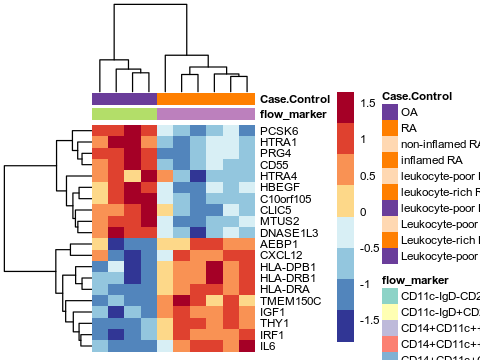

In [216]:
exp <- log2tpm_type[which(rownames(log2tpm_type) %in% markers),]
mat_breaks <- seq(min(exp), max(exp), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}
mat_breaks <- quantile_breaks(exp, n = 11)

annotation_col <- meta_type[, c("flow_marker", "disease")]
colnames(annotation_col)[2] <- "Case.Control"
rownames(annotation_col) <- meta_type$sample_ID
rownames(meta_type) <- meta_type$sample_ID
exp <- exp[,order(annotation_col$flow_marker)]
scale_rows <- function(x) t(scale(t(x)))
exp <- scale_rows(exp) # Z-score
exp[exp > 2] <- 2
exp[exp < -2] <- -2

options(repr.plot.height = 3, repr.plot.width = 4)
p1 <- pheatmap(
  mat = exp,
  border_color = NA,
  color = colorRampPalette(rev(brewer.pal(n = 10, name = "RdYlBu")))(8),
  show_rownames = TRUE,
  show_colnames = FALSE,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  annotation_col = annotation_col,
  annotation_colors = meta_colors,
  fontsize = 7,
  fontsize_row = 7,
  scale = "none"
)
save_pheatmap_pdf <- function(x, filename, width=4, height=3) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(p1, "heatmap_markers_fibro.pdf")

In [165]:
auroc <- function(score, cls) {
  n1 <- sum(!cls)
  n2 <- sum(cls)
  U <- sum(rank(score)[!cls]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

get_markers <- function(log2cpm, cell_clusters) {
  # Compute statistics for each cluster.
  dat_marker <- rbindlist(pblapply(
    X = rownames(log2cpm),
    cl = 20,
    FUN = function(gene_name) {
      gene      <- as.numeric(log2cpm[gene_name,])
      rbindlist(lapply(unique(cell_clusters), function(cell_cluster) {
        ix <- cell_clusters == cell_cluster
        x <- gene[ix]
        x_mean <- mean(x)
        x_sd   <- sd(x)
        x_pct_nonzero <- sum(x > 0) / length(x)
        y <- gene[!ix]
        y_mean <- mean(y)
        y_sd   <- sd(y)
        y_pct_nonzero <- sum(y > 0) / length(y)
        test_w <- wilcox.test(x, y, alternative = "two.sided")
        test_t <- t.test(x, y, alternative = "two.sided")
        data.frame(
          "gene"              = gene_name,
          "cluster"           = cell_cluster,
          "wilcox_pvalue"     = test_w$p.value,
          "ttest_pvalue"      = test_t$p.value,
          "auc"               = auroc(gene, ix),
          "pct_nonzero"       = x_pct_nonzero,
          "pct_nonzero_other" = y_pct_nonzero,
          "log2FC"            = x_mean - y_mean,
          "mean"              = x_mean,
          "sd"                = x_sd,
          "mean_other"        = y_mean,
          "sd_other"          = y_sd
        )
      }))
    }
  ))
  # Check if the mean is highest in this cluster.
  dat_marker[
    ,
    mean_highest := mean >= max(mean),
    by = gene
  ]
  dat_marker[
    ,
    pct_nonzero_highest := pct_nonzero >= max(pct_nonzero),
    by = gene
  ]
  return(dat_marker)
}


# Test each cluster against all cells.
exp_test <- sc_log2cpm[, which(sc_meta$cluster %in% c("SC-F2", "SC-F4"))]
meta_test <- sc_meta[which(sc_meta$cluster %in% c("SC-F2", "SC-F4")),]
all(colnames(sc_log2cpm) == sc_meta$cell_name)

dat_marker_sc <- get_markers(
    exp_test, 
    meta_test$cluster
)

[1] TRUE